In [1]:
import sqlite3
import pandas as pd
import folium
import math
import matplotlib.pyplot as plt
import numpy as np
from Functions import *
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
mapRep_coper(pixel = 195)

### Extracción de datos

In [12]:
df_c, df_embalses, df_rios, df_aemet, df_x = dataExtract(pixel = 195)

#### Ríos

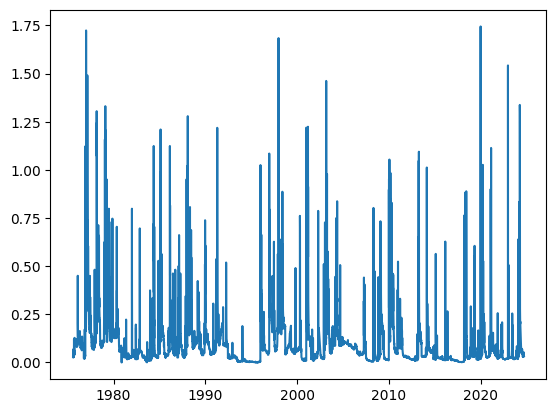

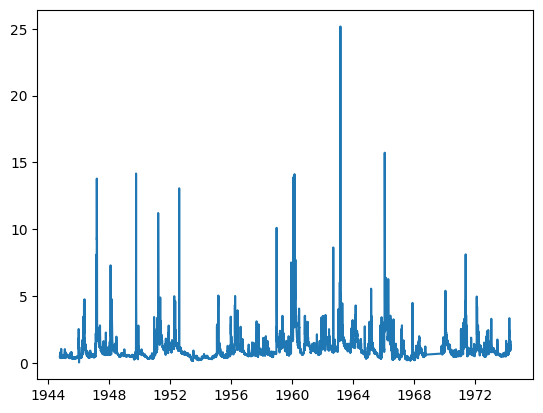

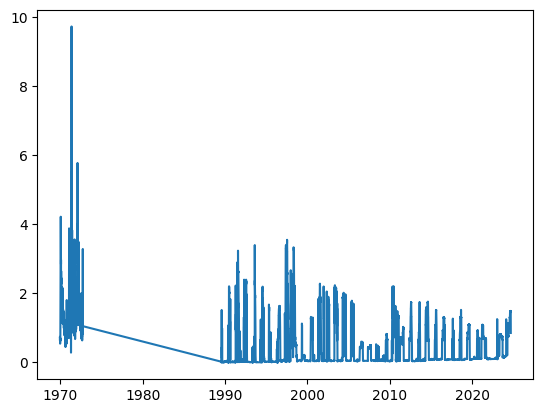

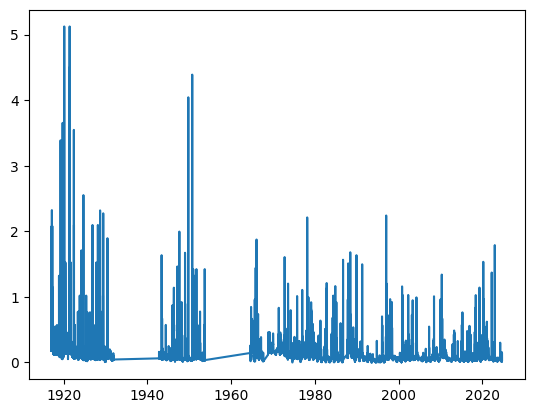

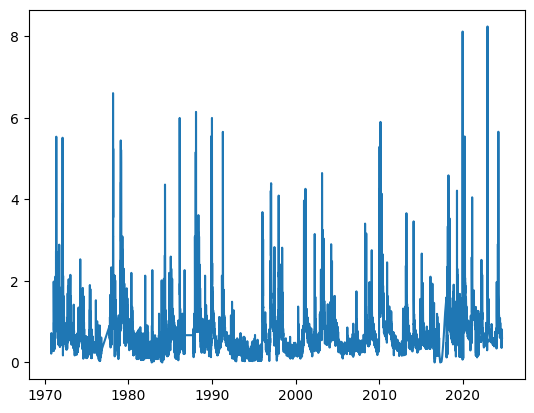

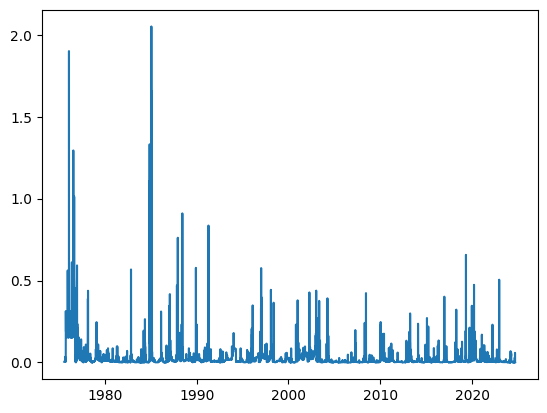

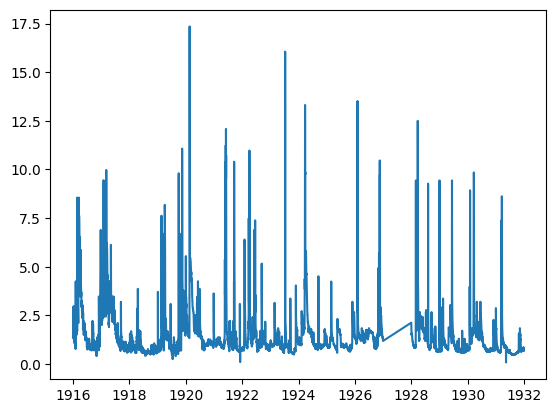

In [29]:
seriesRios = {}
for rio in df_rios['location_id'].unique():
    serie_rio = df_rios[df_rios['location_id'] == rio].drop('location_id', axis = 1).groupby('date').mean()
    seriesRios[rio] =  serie_rio
    plt.plot(serie_rio)
    plt.show()

In [50]:
df_rios = df_rios.groupby('date').mean().drop('location_id', axis = 1)

#### Aemet

In [41]:
df_aemet['location_id'].unique()

array([337], dtype=int64)

Vemos que las precipitaciones y las temperaturas medias entre las tres estaciones son parecidas y que tienen una alta correlación entre ellas

#### Copernicus

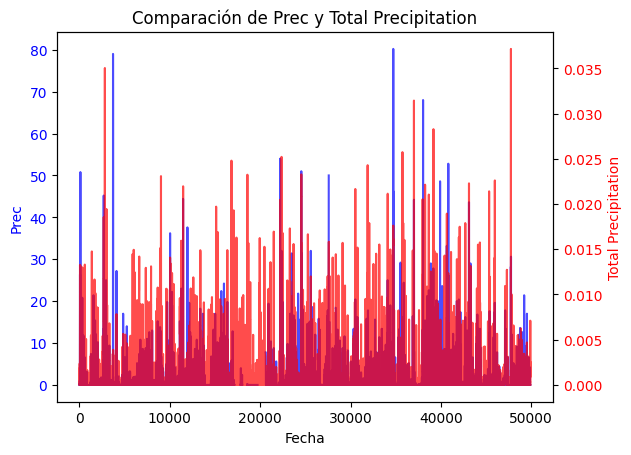

Correlacion entre datos de copernicus de lluvias y aemet de: 0.5497477583565855


In [42]:
# Crear la figura y el primer eje
fig, ax1 = plt.subplots()

# Graficar la primera serie (prec) en el primer eje y
ax1.plot(df_x['prec'], color='blue', label='Prec', alpha=0.7)
ax1.set_xlabel('Fecha')  # Etiqueta del eje x
ax1.set_ylabel('Prec', color='blue')  # Etiqueta del eje y para la primera serie
ax1.tick_params(axis='y', labelcolor='blue')  # Color de los ticks en el eje y para la primera serie

# Crear un segundo eje en el mismo gráfico para la segunda serie
ax2 = ax1.twinx()
ax2.plot(df_x['total_precipitation'], color='red', label='Total Precipitation', alpha=0.7)
ax2.set_ylabel('Total Precipitation', color='red')  # Etiqueta del eje y para la segunda serie
ax2.tick_params(axis='y', labelcolor='red')  # Color de los ticks en el eje y para la segunda serie

# Mostrar la gráfica
plt.title('Comparación de Prec y Total Precipitation')
plt.show()

print('Correlacion entre datos de copernicus de lluvias y aemet de:', df_x['prec'].corr(df_x['total_precipitation']))

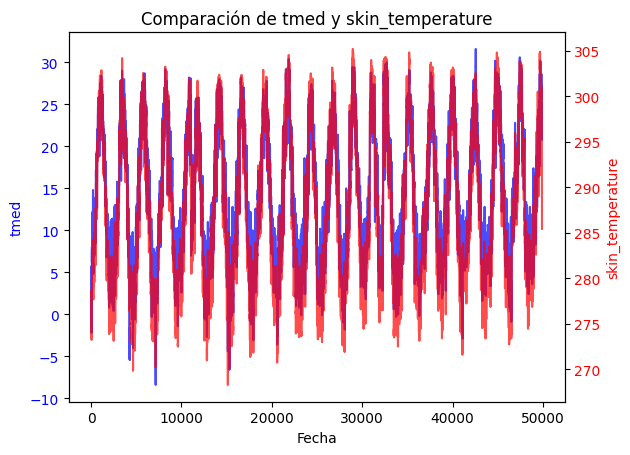

Correlacion entre datos de copernicus de temperaturas y aemet de: 0.981908200608371


In [43]:
# Crear la figura y el primer eje
fig, ax1 = plt.subplots()

# Graficar la primera serie (prec) en el primer eje y
ax1.plot(df_x['tmed'], color='blue', label='Prec', alpha=0.7)
ax1.set_xlabel('Fecha')  # Etiqueta del eje x
ax1.set_ylabel('tmed', color='blue')  # Etiqueta del eje y para la primera serie
ax1.tick_params(axis='y', labelcolor='blue')  # Color de los ticks en el eje y para la primera serie

# Crear un segundo eje en el mismo gráfico para la segunda serie
ax2 = ax1.twinx()
ax2.plot(df_x['skin_temperature'], color='red', label='skin_temperature', alpha=0.7)
ax2.set_ylabel('skin_temperature', color='red')  # Etiqueta del eje y para la segunda serie
ax2.tick_params(axis='y', labelcolor='red')  # Color de los ticks en el eje y para la segunda serie

# Mostrar la gráfica
plt.title('Comparación de tmed y skin_temperature')
plt.show()
print('Correlacion entre datos de copernicus de temperaturas y aemet de:', df_x['tmed'].corr(df_x['skin_temperature']))

### Datos del río

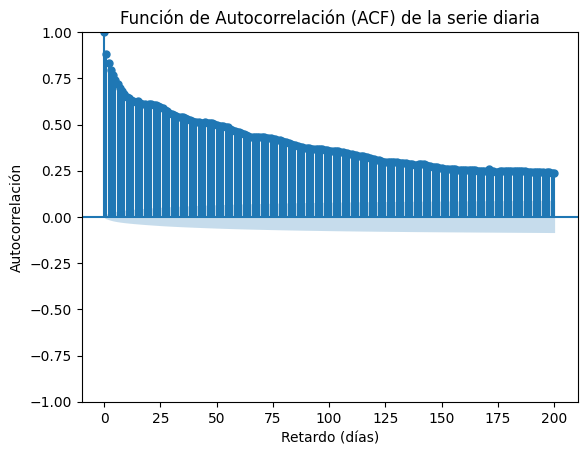

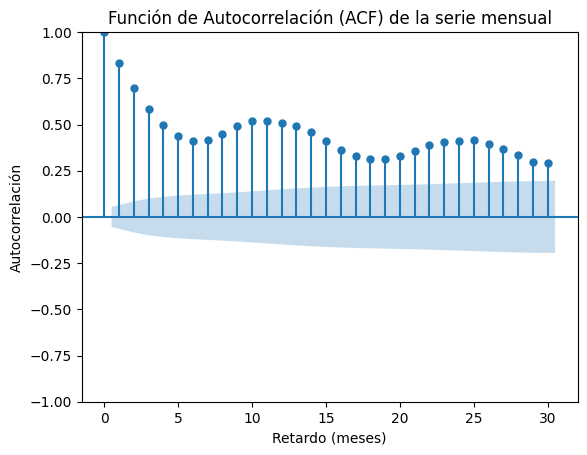

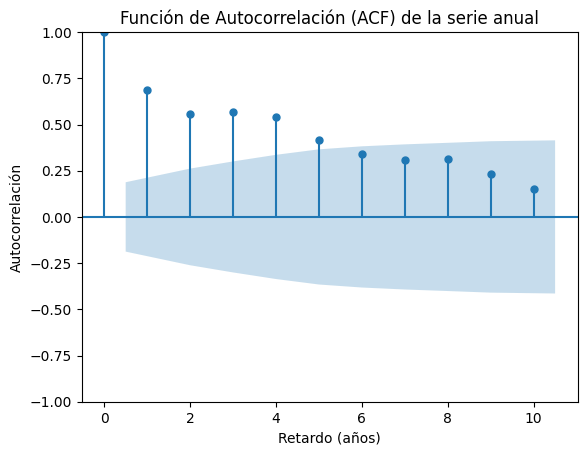

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

df_rios1 = df_rios.copy()

# Autocorrelación diaria
plot_acf(df_rios1['quantity_hm3'], lags=200)
plt.title('Función de Autocorrelación (ACF) de la serie diaria')
plt.xlabel('Retardo (días)')
plt.ylabel('Autocorrelación')
plt.show()

# Autocorrelación mensual
monthly_series = df_rios1.resample('M').sum()  # Cambia a .sum() si quieres acumulados
plot_acf(monthly_series['quantity_hm3'], lags=30)
plt.title('Función de Autocorrelación (ACF) de la serie mensual')
plt.xlabel('Retardo (meses)')
plt.ylabel('Autocorrelación')
plt.show()

# Autocorrelación anual
annualy_series = df_rios1.resample('Y').sum()  # Cambia a .sum() si quieres acumulados
plot_acf(annualy_series['quantity_hm3'], lags=10)
plt.title('Función de Autocorrelación (ACF) de la serie anual')
plt.xlabel('Retardo (años)')
plt.ylabel('Autocorrelación')
plt.show()

#### Relación con las precipitaciones

##### Cantidad absoluta

###### Tiempo natural

In [55]:
#df = df.reset_index()
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
df = df[['date','quantity_hm3', 'total_precipitation', 'prec']]

# Variables para calcular retardos, acumulados y promedios móviles
variables = ['total_precipitation', 'prec']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df['month_start'] = df['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df = df.merge(monthly_agg.drop(['total_precipitation', 'prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')

# Agrupación mensual para calcular los valores agregados por mes
#monthly_agg = df.groupby('month_start')[variables].mean().reset_index() 
# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
#for var in variables:
    #for lag in lags_months:     
        # Crear promedios móviles de los últimos N meses
        #monthly_agg[f'{var}_mean_last{lag - 1} month'] = monthly_agg[var].rolling(window=lag).mean()

# Unir los resultados al DataFrame diario
#df = df.merge(monthly_agg.drop(['total_precipitation', 'prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')
correlaciones = df.drop(['date','month_start'],axis = 1).corr()
correlaciones['quantity_hm3'].sort_values(ascending = True)

total_precipitation_sum_last100 month   -0.045112
total_precipitation_sum_last60 month    -0.037735
prec                                     0.048669
total_precipitation                      0.080041
prec_sum_last60 month                    0.110548
total_precipitation_sum_last1 month      0.123150
prec_sum_last1 month                     0.130181
total_precipitation_sum_last15 month     0.197356
prec_sum_last100 month                   0.202144
total_precipitation_sum_last30 month     0.220402
prec_sum_last15 month                    0.227410
prec_sum_last30 month                    0.235824
total_precipitation_sum_last7 month      0.282370
prec_sum_last7 month                     0.289318
quantity_hm3                             1.000000
Name: quantity_hm3, dtype: float64

###### Tiempo dinámico

In [56]:
#df = df.reset_index()
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
df = df[['date','quantity_hm3', 'total_precipitation', 'prec']]

# Variables para calcular retardos, acumulados y promedios móviles
variables = ['total_precipitation', 'prec']

# Lista de períodos para los cálculos
periods = [1, 7, 15, 30, 60,100]

for period in periods:
    for var in variables:
        # Promedios
        #df[f'{var}_mean_{period}d'] = df[var].rolling(window=period, min_periods=1).mean()
        # Sumas
        df[f'{var}_sum_{period}d'] = df[var].rolling(window=period, min_periods=1).sum()

correlaciones = df.drop(['date'],axis = 1).corr()
correlaciones['quantity_hm3'].sort_values(ascending = True)

prec                            0.048669
prec_sum_1d                     0.048669
total_precipitation             0.080041
total_precipitation_sum_1d      0.080041
prec_sum_7d                     0.112273
total_precipitation_sum_7d      0.140366
prec_sum_15d                    0.196563
total_precipitation_sum_15d     0.204908
total_precipitation_sum_100d    0.242407
total_precipitation_sum_30d     0.243470
total_precipitation_sum_60d     0.249608
prec_sum_100d                   0.255720
prec_sum_30d                    0.259253
prec_sum_60d                    0.270132
quantity_hm3                    1.000000
Name: quantity_hm3, dtype: float64

##### Lluvias en píxeles colindantes

In [65]:
conn = sqlite3.connect('BBDD/aguaCHJucar.db')

cursor = conn.cursor()
query = f'''
    SELECT 
        p.location_id_copernicus, 
        l1.latitude AS latitude_copernicus, l1.longitude AS longitude_copernicus,
        l2.latitude AS latitude_embalses, l2.longitude AS longitude_embalses,
        l3.latitude AS latitude_aemet, l3.longitude AS longitude_aemet,
        l4.latitude AS latitude_rios, l4.longitude AS longitude_rios
    FROM df_pixeles_cercanos p
    -- Relacionar las localizaciones de la tabla df_pixeles_cercanos con las latitudes y longitudes
    LEFT JOIN locations_id l1 ON p.location_id_copernicus = l1.location_id 
    LEFT JOIN locations_id l2 ON p.location_id_embalses = l2.location_id
    LEFT JOIN locations_id l3 ON p.location_id_aemet = l3.location_id
    LEFT JOIN locations_id l4 ON p.location_id_rios_canales = l4.location_id
'''


# Ejecutar la consulta
cursor.execute(query)


# Función para calcular la distancia Haversine
def haversine(lat1, lon1, lat2, lon2):
    # Convertir de grados a radianes
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Diferencias de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula Haversine
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Radio de la Tierra en kilómetros
    R = 6371.0

    # Calcular la distancia
    distance = R * c
    return distance

# Obtener el DataFrame con las coordenadas
df_loc = pd.read_sql_query(query, conn)

# Eliminar filas duplicadas en las columnas relevantes (location_id_copernicus, latitude_copernicus, longitude_copernicus)
df_loc_unique = df_loc[['location_id_copernicus', 'latitude_copernicus', 'longitude_copernicus']].drop_duplicates()

# Obtener las coordenadas del location_id_copernicus == 189
target_location = df_loc_unique[df_loc_unique['location_id_copernicus'] == 195]
target_lat = target_location['latitude_copernicus'].values[0]
target_lon = target_location['longitude_copernicus'].values[0]

# Calcular la distancia a todos los demás location_id_copernicus
df_loc_unique['distance_to_195'] = df_loc_unique.apply(
    lambda row: haversine(target_lat, target_lon, row['latitude_copernicus'], row['longitude_copernicus']),
    axis=1
)

# Filtrar los location_id_copernicus colindantes (por ejemplo, aquellos con distancia menor a 1 km)
colindantes = df_loc_unique[df_loc_unique['distance_to_195'] < 80]


In [66]:
colindantes

,location_id_copernicus,latitude_copernicus,longitude_copernicus,distance_to_195
0,189,39.174,-1.755,55.597463
6,190,39.174,-1.255,70.253137
42,188,39.174,-2.255,70.253137
599,194,39.674,-2.255,42.792719
617,200,40.174,-2.255,70.064208
619,201,40.174,-1.755,55.597463
622,195,39.674,-1.755,0.000000
629,202,40.174,-1.255,70.064208
887,196,39.674,-1.255,42.792719


In [67]:
m = folium.Map(location=[target_lat, target_lon], zoom_start=12)

# Añadir el marcador para el `location_id_copernicus == 189`
folium.Marker(
    location=[target_lat, target_lon],
    popup='location_id_copernicus == 195',
    icon=folium.Icon(color='red')
).add_to(m)

# Añadir marcadores para los puntos colindantes
for _, row in colindantes.iterrows():
    folium.Marker(
        location=[row['latitude_copernicus'], row['longitude_copernicus']],
        popup=f'location_id_copernicus == {row["location_id_copernicus"]}, Distancia: {row["distance_to_195"]:.2f} km',
        icon=folium.Icon(color='blue')
    ).add_to(m)
    
    # Añadir una línea entre `location_id_copernicus == 189` y el punto colindante
    folium.PolyLine(
        locations=[(target_lat, target_lon), (row['latitude_copernicus'], row['longitude_copernicus'])],
        color='green',
        weight=2.5,
        opacity=1
    ).add_to(m)
m

In [68]:
locations_colindantes  = colindantes['location_id_copernicus'].to_list()
locations_str = ', '.join(map(str, locations_colindantes))
query = f'''
        SELECT 
            d.date,
            c.location_id ,
            c.total_precipitation
            FROM df_copernicus c JOIN df_date d ON d.date_id = c.date_id  WHERE c.location_id IN ({locations_str});
        '''
# Ejecutar la consulta
cursor.execute(query)


df_colindantes_coper = pd.read_sql_query(query, conn)

In [69]:
df_colindantes_coper_pivot = df_colindantes_coper.pivot(index='date', columns='location_id', values='total_precipitation')

In [70]:
df_colindantes_coper_pivot.corr()

location_id,188,189,190,194,195,196,200,201,202
location_id,,,,,,,,,
188,1.000000,0.960587,0.855361,0.946064,0.942079,0.862620,0.832921,0.847008,0.791376
189,0.960587,1.000000,0.952246,0.888078,0.935235,0.918764,0.757338,0.812075,0.808411
190,0.855361,0.952246,1.000000,0.762615,0.854574,0.938757,0.630867,0.720428,0.787998
194,0.946064,0.888078,0.762615,1.000000,0.959437,0.847469,0.954955,0.938612,0.833088
195,0.942079,0.935235,0.854574,0.959437,1.000000,0.944282,0.889168,0.947105,0.918814
196,0.862620,0.918764,0.938757,0.847469,0.944282,1.000000,0.767100,0.870290,0.926480
200,0.832921,0.757338,0.630867,0.954955,0.889168,0.767100,1.000000,0.964114,0.830198
201,0.847008,0.812075,0.720428,0.938612,0.947105,0.870290,0.964114,1.000000,0.937073
202,0.791376,0.808411,0.787998,0.833088,0.918814,0.926480,0.830198,0.937073,1.000000


In [71]:
df_colindantes_coper_pivot = df_colindantes_coper_pivot.reset_index()

In [72]:
df_colindantes_coper_pivot['date'] = pd.to_datetime(df_colindantes_coper_pivot['date'])

In [75]:
df_merge = pd.merge(df,df_colindantes_coper_pivot, on ='date')[['date','quantity_hm3',188,189,190,194,195,196,200,201,202]]

# Variables para calcular retardos, acumulados y promedios móviles
variables = [188,189,190,194,195,196,200,201,202]
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df_merge['month_start'] = df_merge['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df_merge.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df_merge = df_merge.merge(monthly_agg.drop( [188,189,190,194,195,196,200,201,202], axis = 1), left_on='month_start', right_on='month_start', how='left')

# Agrupación mensual para calcular los valores agregados por mes
#monthly_agg = df.groupby('month_start')[variables].mean().reset_index() 
# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
#for var in variables:
    #for lag in lags_months:     
        # Crear promedios móviles de los últimos N meses
        #monthly_agg[f'{var}_mean_last{lag - 1} month'] = monthly_agg[var].rolling(window=lag).mean()

# Unir los resultados al DataFrame diario
#df = df.merge(monthly_agg.drop(['total_precipitation', 'prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')
correlaciones = df_merge.drop(['date','month_start'],axis = 1).corr()
correlaciones['quantity_hm3'].sort_values(ascending = True)[1:50]

190_sum_last100 month   -0.157640
196_sum_last100 month   -0.153006
189_sum_last100 month   -0.136351
202_sum_last60 month    -0.097048
188_sum_last100 month   -0.091820
195_sum_last100 month   -0.087091
188_sum_last60 month    -0.066418
194_sum_last60 month    -0.061183
196_sum_last60 month    -0.058414
195_sum_last60 month    -0.057744
189_sum_last60 month    -0.049276
200_sum_last60 month    -0.048224
201_sum_last60 month    -0.048068
190_sum_last60 month    -0.040173
194_sum_last100 month   -0.020180
201_sum_last100 month   -0.003828
190                      0.047177
200_sum_last100 month    0.053567
189                      0.054393
188                      0.064277
190_sum_last1 month      0.069262
196                      0.070685
194                      0.073402
195                      0.078745
200                      0.083987
189_sum_last1 month      0.090073
194_sum_last1 month      0.091370
200_sum_last1 month      0.095094
201                      0.095820
202           

##### Lluvias con frecuencia baja

In [166]:
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')

C:\Users\idelatorre\AppData\Local\Temp\ipykernel_22072\4035553041.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['prec'], shade=True, color="blue")


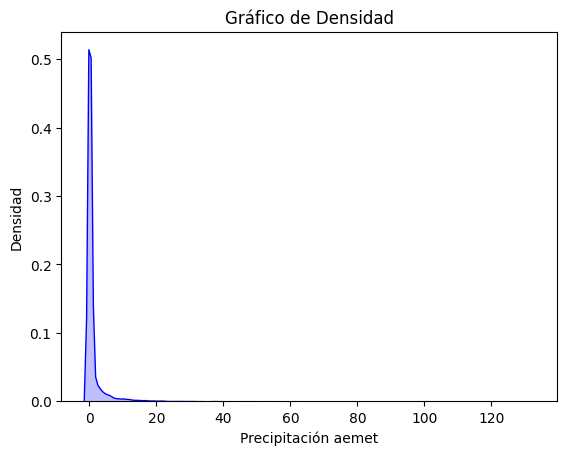

In [187]:
import seaborn as sns

sns.kdeplot(df['prec'], shade=True, color="blue")

plt.title('Gráfico de Densidad')
plt.xlabel('Precipitación aemet')
plt.ylabel('Densidad')

plt.show()


In [180]:
df_precBaja = df[df['prec']<df['prec'].mean()]
df_tpBaja = df[df['total_precipitation']<df['total_precipitation'].mean()]

In [184]:
# Variables para calcular retardos, acumulados y promedios móviles
variables = ['prec']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df_precBaja['month_start'] = df_precBaja['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df_precBaja.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df_precBaja = df_precBaja.merge(monthly_agg.drop( ['prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')


C:\Users\idelatorre\AppData\Local\Temp\ipykernel_22072\338456587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_precBaja['month_start'] = df_precBaja['date'].dt.to_period('M').dt.start_time


In [186]:
df_precBaja.corr()['quantity_hm3']

date                     -0.457983
total_precipitation      -0.008790
skin_temperature          0.281741
evaporation              -0.225397
runoff                   -0.009046
snowfall                 -0.021748
high_vegetation_cover    -0.025630
low_vegetation_cover      0.025630
soil_water               -0.123034
tmed                      0.273247
prec                     -0.043069
quantity_hm3              1.000000
month_start              -0.457995
prec_sum_last1 month     -0.181411
prec_sum_last7 month     -0.081163
prec_sum_last15 month    -0.176996
prec_sum_last30 month    -0.081423
prec_sum_last60 month    -0.076841
prec_sum_last100 month   -0.127092
Name: quantity_hm3, dtype: float64

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
df = df[['date','quantity_hm3', 'total_precipitation', 'prec']]

# Variables para calcular retardos, acumulados y promedios móviles
variables = ['total_precipitation', 'prec']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df['month_start'] = df['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df = df.merge(monthly_agg.drop(['total_precipitation', 'prec'], axis = 1), left_on='month_start', right_on='month_start', how='left')

vars = ['quantity_hm3','total_precipitation_sum_last1 month',
       'total_precipitation_sum_last7 month',
       'total_precipitation_sum_last15 month',
       'total_precipitation_sum_last30 month',
       'total_precipitation_sum_last60 month',
       'total_precipitation_sum_last100 month', 'prec_sum_last1 month',
       'prec_sum_last7 month', 'prec_sum_last15 month',
       'prec_sum_last30 month', 'prec_sum_last60 month',
       'prec_sum_last100 month']
for i in vars:
    estacionalidad = seasonal_decompose(df[i].dropna(), model='additive', period=50).seasonal
    df[f'season_{i}'] = estacionalidad

df_estacionalidades = df[[i for i in df.columns if i[0:6] == 'season']]

df_estacionalidades.corr()['season_quantity_hm3'].sort_values(ascending = False)

#df['Estacionalidad_precipitacion_15_dias_copenicus'] = prec_cop.seasonal
#df['Estacionalidad_precipitacion_15_dias_aemet'] = prec_aemet.seasonal
#df['Estacionalidad_cantidad_agua'] = prec_agua.seasonal

season_quantity_hm3                             1.000000
season_prec_sum_last30 month                    0.375044
season_total_precipitation_sum_last30 month     0.244519
season_total_precipitation_sum_last15 month     0.100837
season_total_precipitation_sum_last1 month      0.073372
season_prec_sum_last15 month                    0.021068
season_total_precipitation_sum_last60 month    -0.160868
season_total_precipitation_sum_last100 month   -0.404175
season_prec_sum_last100 month                  -0.448571
season_prec_sum_last60 month                   -0.465108
season_prec_sum_last7 month                    -0.474074
season_total_precipitation_sum_last7 month     -0.522185
season_prec_sum_last1 month                    -0.584958
Name: season_quantity_hm3, dtype: float64

Todo lo que hemos hecho lo encapsulamos en funciones, functions.py y buscamos mejores correlaciones de lluvias con cantidad de agua

In [16]:
from Functions import *
from statsmodels.tsa.seasonal import seasonal_decompose

In [17]:
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')

In [18]:
df = df[['date','total_precipitation','quantity_hm3']]

In [77]:
lags_dict = {'D': list(range(1, 301)), 'M': list(range(1, 101)), 'Y': list(range(1, 21))}
df_est_aggNat_corr = {}
for frecuent, lags in lags_dict.items():
    df_est_aggNat_corr[frecuent] = {}
    # Calcular retardos y correlaciones
    df_aggNat = retardAgg_tNat(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)
    df_aggNat = df_aggNat.drop(f'{frecuent}_start', axis = 1)
    vars = df_aggNat.drop(['date', 'quantity_hm3'], axis = 1).columns
    for est in range(10,210,10):
        df_est_aggNat_corr[frecuent][est] = {}
        estacionalidad_quantity = seasonal_decompose(df_aggNat['quantity_hm3'].dropna(), model='additive', period=est).trend
        for var in vars:
            estacionalidad_var = seasonal_decompose(df_aggNat[var].dropna(), model='additive', period=est).trend
            corr_aggNat = estacionalidad_var.corr(estacionalidad_quantity)
            df_est_aggNat_corr[frecuent][est][var] = corr_aggNat

C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragme

In [80]:
pd.DataFrame(df_est_aggNat_corr['M']).T

,total_precipitation,total_precipitation_sum_last1M,total_precipitation_sum_last2M,total_precipitation_sum_last3M,total_precipitation_sum_last4M,total_precipitation_sum_last5M,total_precipitation_sum_last6M,total_precipitation_sum_last7M,total_precipitation_sum_last8M,total_precipitation_sum_last9M,...,total_precipitation_sum_last91M,total_precipitation_sum_last92M,total_precipitation_sum_last93M,total_precipitation_sum_last94M,total_precipitation_sum_last95M,total_precipitation_sum_last96M,total_precipitation_sum_last97M,total_precipitation_sum_last98M,total_precipitation_sum_last99M,total_precipitation_sum_last100M
10,-0.093000,-0.170777,-0.189955,-0.190979,-0.178545,-0.171571,-0.170017,-0.172691,-0.181904,-0.180611,...,-0.192956,-0.185261,-0.188009,-0.197571,-0.210170,-0.228831,-0.240787,-0.232561,-0.219101,-0.204217
20,-0.128477,-0.178164,-0.196287,-0.196805,-0.184109,-0.177523,-0.176472,-0.179353,-0.188754,-0.186402,...,-0.197406,-0.189816,-0.192493,-0.201872,-0.215856,-0.234536,-0.245897,-0.238281,-0.224502,-0.209779
30,-0.151318,-0.184346,-0.201060,-0.201498,-0.189165,-0.182380,-0.181778,-0.185616,-0.194598,-0.191920,...,-0.201196,-0.194254,-0.196746,-0.205886,-0.221353,-0.239992,-0.250616,-0.243778,-0.229721,-0.215211
40,-0.165684,-0.191322,-0.205191,-0.205838,-0.194303,-0.187288,-0.186967,-0.191537,-0.199379,-0.197252,...,-0.204791,-0.198787,-0.201004,-0.210224,-0.226786,-0.245223,-0.255090,-0.249073,-0.234974,-0.220603
50,-0.175304,-0.198509,-0.209285,-0.210041,-0.199472,-0.192456,-0.192422,-0.197324,-0.203328,-0.202298,...,-0.208624,-0.203517,-0.205758,-0.215368,-0.232412,-0.250399,-0.259584,-0.254269,-0.240524,-0.226249
60,-0.182569,-0.205458,-0.213484,-0.214313,-0.204895,-0.197895,-0.198253,-0.202963,-0.207240,-0.207354,...,-0.212614,-0.208384,-0.210722,-0.220956,-0.238134,-0.255421,-0.263991,-0.259242,-0.246215,-0.232031
70,-0.189954,-0.212231,-0.217921,-0.218786,-0.210593,-0.203712,-0.204181,-0.208018,-0.211291,-0.212605,...,-0.216719,-0.213277,-0.215972,-0.226855,-0.243892,-0.260261,-0.268268,-0.264028,-0.251935,-0.237842
80,-0.196889,-0.218295,-0.222381,-0.223410,-0.216499,-0.209839,-0.210074,-0.212514,-0.215386,-0.218105,...,-0.220972,-0.218291,-0.221627,-0.232996,-0.249619,-0.264948,-0.272469,-0.268751,-0.257643,-0.243678
90,-0.202842,-0.223256,-0.226772,-0.228316,-0.222586,-0.216318,-0.216161,-0.217057,-0.219759,-0.223905,...,-0.225407,-0.223356,-0.227574,-0.239286,-0.255271,-0.269523,-0.276597,-0.273425,-0.263251,-0.249533
100,-0.206918,-0.227662,-0.231062,-0.233449,-0.228731,-0.222872,-0.222079,-0.221664,-0.224502,-0.229928,...,-0.229999,-0.228588,-0.233777,-0.245706,-0.260881,-0.274072,-0.280733,-0.278097,-0.268747,-0.255428


In [ ]:
# lags_dict = {'D': list(range(1, 301)), 'M': list(range(1, 101)), 'Y': list(range(1, 21))}
df_est_aggNat_corr = {}

for frecuent, lags in lags_dict.items():
    # Inicializar clave de frecuencia si no existe
    if frecuent not in df_est_aggNat_corr:
        df_est_aggNat_corr[frecuent] = {}

    # Calcular retardos y correlaciones
    df_aggNat = retardAgg_tNat(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)
    vars = df_aggNat.drop(['date', 'quantity_hm3'], axis=1).columns
    df_aggNat = df_aggNat.drop('D_start', axis=1, errors='ignore')  # Ignorar errores si no existe

    for est in range(10, 210, 10):
        # Inicializar clave de estacionalidad si no existe
        if est not in df_est_aggNat_corr[frecuent]:
            df_est_aggNat_corr[frecuent][est] = {}

        # Calcular estacionalidades
        estacionalidad_quantity = seasonal_decompose(df_aggNat['quantity_hm3'].dropna(), model='additive', period=est).seasonal

        for var in vars:
            # Calcular estacionalidad de la variable
            estacionalidad_var = seasonal_decompose(df_aggNat[var].dropna(), model='additive', period=est).seasonal
            
            # Calcular correlación
            corr_aggNat = estacionalidad_var.corr(estacionalidad_quantity)
            
            # Asignar el resultado al diccionario
            df_est_aggNat_corr[frecuent][est][var] = corr_aggNat


In [42]:
df_dia = pd.DataFrame()
df_mes = pd.DataFrame()
df_año = pd.DataFrame()
lags_dict = {'D': list(range(1, 301)), 'M': list(range(1, 101)), 'Y': list(range(1, 21))}
for frecuent, lags in lags_dict.items():
    # Calcular retardos y correlaciones
    df_aggNat = retardAgg_tNat(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)
    vars = df_aggNat.drop('date', axis = 1).columns
    for i in vars:
            estacionalidad = seasonal_decompose(df_aggNat[i].dropna(), model='additive', period=50).seasonal
            df_aggNat[f'season_{i}_{est}'] = estacionalidad
            
    df_estacionalidades_aggNat = df_aggNat[[i for i in df_aggNat.columns if i[0:6] == 'season']]
    corr_aggNat = df_estacionalidades_aggNat.corr()['season_quantity_hm3']

    ####################################
    df_avgNat = retardAvg_tNat(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)
    vars = df_avgNat.drop('date', axis = 1).columns
    for i in vars:
            estacionalidad = seasonal_decompose(df_avgNat[i].dropna(), model='additive', period=50).seasonal
            df_avgNat[f'season_{i}{est}'] = estacionalidad
        
    df_estacionalidades_avgNat = df_avgNat[[i for i in df_avgNat.columns if i[0:6] == 'season']]
    corr_avgNat = df_estacionalidades_avgNat.corr()['season_quantity_hm3']

    #####################################
    df_corr = pd.concat([corr_aggNat, corr_avgNat])
    if frecuent == 'D':
        df_dia = pd.concat([df_corr, df_dia])
    elif frecuent == 'M':
        df_mes = pd.concat([df_corr, df_mes])
    elif frecuent == 'Y':
        df_año = pd.concat([df_corr, df_año])

C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_agg[f'{var}_sum_last{lag}{frec}'] = monthly_agg[var].rolling(window=lag).sum()
C:\Users\idelatorre\Documents\Water UV\Water-Prediction\Functions.py:218: PerformanceWarning: DataFrame is highly fragme

KeyError: 'season_quantity_hm3'

In [46]:
df_estacionalidades_aggNat.columns

Index(['season_total_precipitation_90', 'season_quantity_hm3_90',
       'season_D_start_90', 'season_total_precipitation_sum_last1D_90',
       'season_total_precipitation_sum_last2D_90',
       'season_total_precipitation_sum_last3D_90',
       'season_total_precipitation_sum_last4D_90',
       'season_total_precipitation_sum_last5D_90',
       'season_total_precipitation_sum_last6D_90',
       'season_total_precipitation_sum_last7D_90',
       ...
       'season_total_precipitation_sum_last291D_90',
       'season_total_precipitation_sum_last292D_90',
       'season_total_precipitation_sum_last293D_90',
       'season_total_precipitation_sum_last294D_90',
       'season_total_precipitation_sum_last295D_90',
       'season_total_precipitation_sum_last296D_90',
       'season_total_precipitation_sum_last297D_90',
       'season_total_precipitation_sum_last298D_90',
       'season_total_precipitation_sum_last299D_90',
       'season_total_precipitation_sum_last300D_90'],
      dtype='o

In [ ]:
df_estacionalidades_aggNat.corr()['season_quantity_hm3']

In [63]:
df_dia[df_dia['quantity_hm3']>0]

,index,quantity_hm3
1,quantity_hm3,1.0
1,quantity_hm3,1.0


In [64]:
df_mes[df_mes['quantity_hm3']>0]

,index,quantity_hm3
1,quantity_hm3,1.0
1,quantity_hm3,1.0


In [65]:
df_año[df_año['quantity_hm3']>0]

,index,quantity_hm3
1,quantity_hm3,1.0
1,quantity_hm3,1.0


In [246]:
retardAgg_tDin(df=df, vars=['total_precipitation'], lags=lags, frec=frecuent)

ValueError: invalid on specified as date, must be a column (of DataFrame), an Index or None

In [249]:
df

,date,total_precipitation,skin_temperature,evaporation,runoff,snowfall,high_vegetation_cover,low_vegetation_cover,soil_water,tmed,prec,quantity_hm3,D_start
0,1979-12-25,0.004725,279.58880,-0.000654,7.036887e-05,0.000000e+00,0.532379,0.466477,0.000008,8.500000,4.500000,2.611872,1979-12-25
1,1979-12-26,0.000028,276.78476,-0.000585,1.243316e-07,0.000000e+00,0.532379,0.466477,0.000008,3.600000,0.000000,2.664576,1979-12-26
2,1979-12-27,0.000000,274.31525,-0.000369,0.000000e+00,2.384186e-07,0.532379,0.466477,0.000008,2.200000,0.000000,2.664576,1979-12-27
3,1979-12-28,0.000168,277.16278,-0.000210,1.043314e-06,0.000000e+00,0.532379,0.466477,0.000008,5.800000,0.000000,2.664576,1979-12-28
4,1979-12-29,0.000055,278.06170,-0.000474,1.556473e-07,0.000000e+00,0.532379,0.466477,0.000008,6.300000,0.000000,2.717280,1979-12-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14997,2024-09-01,0.000019,300.68950,-0.000106,0.000000e+00,0.000000e+00,0.293182,0.686639,0.000003,25.966667,0.066667,0.760147,2024-09-01
14998,2024-09-02,0.004281,300.15360,-0.000280,1.683459e-05,0.000000e+00,0.293182,0.686639,0.000003,24.700000,11.500000,0.759370,2024-09-02
14999,2024-09-03,0.001827,298.29828,-0.000694,6.807037e-06,0.000000e+00,0.293182,0.686639,0.000003,25.066667,0.133333,0.793757,2024-09-03
15000,2024-09-04,0.000541,296.73508,-0.000653,1.996756e-06,0.000000e+00,0.293182,0.686639,0.000003,23.800000,0.000000,0.785549,2024-09-04


#### Regresión

In [79]:
df = pd.merge(df_x, df_rios, on = 'date', how = 'inner')
# Variables para calcular retardos, acumulados y promedios móviles
variables = ['prec','total_precipitation']
lags_months = [1, 7, 15, 30, 60,100]  # Retardos y acumulados en meses

# Crear un índice basado en meses para agrupar por mes
df['month_start'] = df['date'].dt.to_period('M').dt.start_time

# Agrupación mensual para calcular los valores agregados por mes
monthly_agg = df.groupby('month_start')[variables].sum().reset_index()

# Iterar sobre las variables y calcular retardos, acumulados y promedios móviles
for var in variables:
    for lag in lags_months:        
        # Crear acumulados de los últimos N meses
        monthly_agg[f'{var}_sum_last{lag} month'] = monthly_agg[var].rolling(window=lag).sum()
# Unir los resultados al DataFrame diario
df = df.merge(monthly_agg.drop( ['prec','total_precipitation'], axis = 1), left_on='month_start', right_on='month_start', how='left').dropna()


In [80]:
import statsmodels.api as sm
predictors = ['prec_sum_last1 month', 'prec_sum_last7 month', 'prec_sum_last15 month',
       'prec_sum_last30 month', 'prec_sum_last60 month',
       'prec_sum_last100 month', 'total_precipitation_sum_last1 month',
       'total_precipitation_sum_last7 month',
       'total_precipitation_sum_last15 month',
       'total_precipitation_sum_last30 month',
       'total_precipitation_sum_last60 month',
       'total_precipitation_sum_last100 month']

X = df[predictors]
y = df['quantity_hm3']

# Agregar una constante para el intercepto
X = sm.add_constant(X)

# Ajustar el modelo de regresión
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           quantity_hm3   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     555.7
Date:                Mon, 25 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:24:26   Log-Likelihood:                 16446.
No. Observations:               28700   AIC:                        -3.287e+04
Df Residuals:                   28687   BIC:                        -3.276e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.1682      0.046     -3.648      0.000      -0.259      -0.078
prec_sum_last1 month                  -5.225e-05   7.27e-06     -7.190      0.000   -6.65e-05    -3.8e-05
prec_sum_last7 month                      0.0001   3.51e-06     31.889      0.000       0.000       0.000
prec_sum_last15 month                  3.087e-05   2.48e-06     12.455      0.000     2.6e-05    3.57e-05
prec_sum_last30 month                 -3.451e-06   1.28e-06     -2.703      0.007   -5.95e-06   -9.49e-07
prec_sum_last60 month                  2.772e-05   1.21e-06     22.890      0.000    2.54e-05    3.01e-05
prec_sum_last100 month                -1.393e-05   1.16e-06    -11.998      0.000   -1.62e-05   -1.17e-05
total_precipitation_sum_last1 month       0.0758      0.008      9.231      0.000       0.060       0.092
total_precipitation_sum_last7 month      -0.0881      0.004    -22.948      0.000      -0.096      -0.081
total_precipitation_sum_last15 month     -0.0938      0.004    -24.075      0.000      -0.101      -0.086
total_precipitation_sum_last30 month      0.0529      0.003     19.499      0.000       0.048       0.058
total_precipitation_sum_last60 month     -0.0293      0.002    -17.977      0.000      -0.033      -0.026
total_precipitation_sum_last100 month     0.0250      0.002     12.254      0.000       0.021       0.029
==============================================================================
Omnibus:                    23297.773   Durbin-Watson:                   0.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1393817.005
Skew:                           3.488   Prob(JB):                         0.00
Kurtosis:                      36.420   Cond. No.                     1.48e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Arbol de regresión

In [108]:
df = df.drop(['trend_prec_cop',
'trend_prec_aemet',
'trend_prec_agua',
'seas_prec_cop',
'seas_prec_aemet',
'seas_prec_agua'], axis = 1)

In [112]:
df = df.set_index('date')

In [113]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop(columns=['quantity_hm3'])
y = df['quantity_hm3']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el árbol de regresión
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

importancias = tree.feature_importances_

# Crear un DataFrame para visualización
importancia_df = pd.DataFrame({'Variable': X.columns, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)

# Predicciones
y_pred = tree.predict(X_test)

# Métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"R² (coeficiente de determinación): {r2}")

Error cuadrático medio (MSE): 0.4783994591918622
R² (coeficiente de determinación): 0.09053639881517317


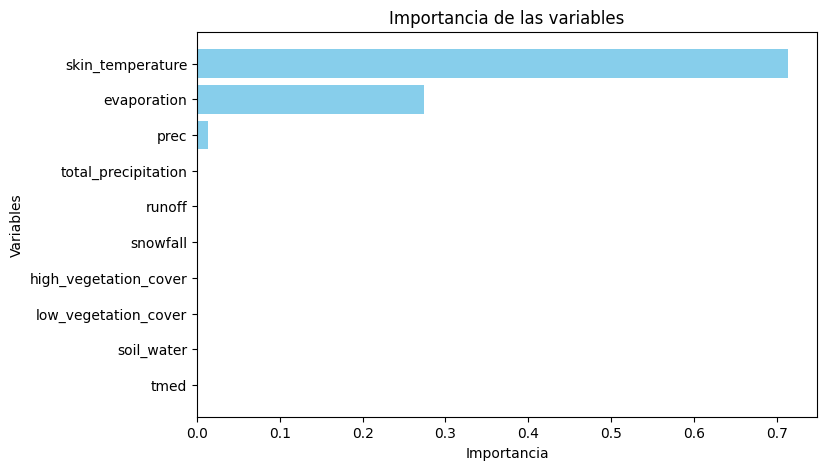

In [115]:
plt.figure(figsize=(8, 5))
plt.barh(importancia_df['Variable'], importancia_df['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de las variables')
plt.gca().invert_yaxis()
plt.show()

#### Regresión lineal

In [116]:
import statsmodels.api as sm

X = df[['skin_temperature', 'evaporation', 'prec']]

# Añadir una constante para el intercepto
X = sm.add_constant(X)

y = df['quantity_hm3']
model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           quantity_hm3   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     571.4
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:21:34   Log-Likelihood:                -15539.
No. Observations:               15002   AIC:                         3.109e+04
Df Residuals:                   14998   BIC:                         3.112e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.3518      0.199    -26.854      0.000      -5.742      -4.961
skin_temperature     0.0202      0.001     28.821      0.000       0.019       0.022
evaporation       -158.9714      7.905    -20.110      0.000    -174.467    -143.476
prec                -0.0027      0.001     -1.827      0.068      -0.006       0.000
==============================================================================
Omnibus:                     5197.640   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16522.763
Skew:                           1.802   Prob(JB):                         0.00
Kurtosis:                       6.667   Cond. No.                     4.08e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
correlaciones = df.corr()

correlaciones_quantity_hm3 = correlaciones['quantity_hm3']
correlaciones_filtradas = correlaciones_quantity_hm3[abs(correlaciones_quantity_hm3) > 0.2]

# Ordenar las correlaciones en orden descendente
correlaciones_filtradas = correlaciones_filtradas.sort_values(ascending=False)
correlaciones_filtradas